# Churn Prediction

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

# Importing required packages for visualization
from IPython.display import Image  
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV,GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, scale, PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report

## Read and Inspect Data

In [3]:
names = ["CPL_wrt_BC","client_state","duration","num_prods", "calls","CPL_wrt_self","churn","avg_budget","BC","clicks"]
df = pd.read_csv("data.csv", names = names)
df.head()

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,BC,clicks
0,0.000000,AZ,73,6,2,NaN,1,10082.152554,Beauty & Personal Care,107
1,-0.623618,CA,1,1,3,0.000000,0,133.928571,"Shopping, Collectibles & Gifts (General)",79
2,0.007905,NY,102,2,8,-0.292008,0,3935.017462,"Personal Services (Weddings, Cleaners, etc.)",90
3,-0.104900,MN,6,1,5,0.587206,0,461.538462,Travel,112
4,-0.013057,NJ,34,1,6,-0.955335,1,314.705882,Health & Fitness,95


In [4]:
df.shape

(10000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CPL_wrt_BC    10000 non-null  float64
 1   client_state  10000 non-null  object 
 2   duration      10000 non-null  int64  
 3   num_prods     10000 non-null  int64  
 4   calls         10000 non-null  int64  
 5   CPL_wrt_self  8908 non-null   float64
 6   churn         10000 non-null  int64  
 7   avg_budget    10000 non-null  float64
 8   BC            10000 non-null  object 
 9   clicks        10000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,clicks
count,10000.000000,10000.000000,10000.000000,10000.000000,8908.000000,10000.00000,10000.000000,10000.000000
mean,-0.068958,27.669200,1.327200,4.526100,0.602664,0.20000,1512.601132,99.214900
std,0.491693,25.500847,0.816582,2.859185,11.135854,0.40002,3473.160720,31.701757
min,-0.994590,1.000000,0.000000,0.000000,-1.000000,0.00000,9.090909,13.000000
25%,-0.103273,6.000000,1.000000,2.000000,-0.255226,0.00000,476.056955,76.000000
50%,-0.088810,19.000000,1.000000,5.000000,0.000000,0.00000,907.839383,96.000000
75%,-0.048530,42.000000,1.000000,7.000000,0.311280,0.00000,1666.499256,119.000000
max,19.088412,118.000000,11.000000,9.000000,841.288094,1.00000,148555.594376,253.000000


In [7]:
df.isnull().sum()

CPL_wrt_BC         0
client_state       0
duration           0
num_prods          0
calls              0
CPL_wrt_self    1092
churn              0
avg_budget         0
BC                 0
clicks             0
dtype: int64

## Exploratory Data Analysis

### Univariate Analysis

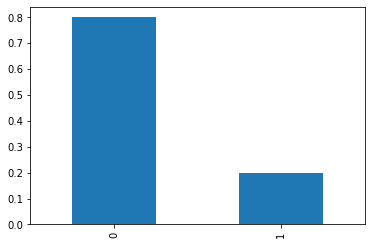

In [8]:
# to check class imbalance
df.churn.value_counts(normalize=True).plot.bar()
plt.show()

Nearly 92% of the customers are non-churners. We need to handle this class imbalance before building models

In [9]:
df['BC'].nunique()

31

In [10]:
#Analysing distribution of clients in BC
df['BC'].value_counts(ascending=True)

Government & Politics                              3
Business Opportunities                             5
Religion & Spirituality                            9
Community, Garage Sales & Organizations           11
Farming & Agriculture                             18
Career & Employment                               20
Toys & Hobbies                                    27
Electronics & Photo                               34
Computers, Telephony & Internet                   35
Arts & Entertainment                              82
Finance & Insurance                               84
Apparel / Fashion & Jewelry                       88
Restaurants & Food                               115
Beauty & Personal Care                           196
Dentists & Dental Services                       218
Animals & Pets                                   221
Sports & Recreation                              259
Real Estate                                      280
Furniture                                     

In [11]:
df['client_state'].nunique()

51

In [12]:
#Analysing distribution of clients in states
df['client_state'].value_counts(ascending=True)

WY       1
WV       3
ND       6
VT       8
AK      10
MT      10
NM      10
SD      15
HI      18
AR      18
ID      23
DE      27
NE      29
KY      34
OK      36
MS      38
IA      40
RI      41
DC      42
AL      47
KS      51
UT      52
NH      53
CT      54
ME      54
SC      63
NV      66
LA      84
WI      90
TN      96
MI     110
IN     128
MN     137
OR     144
NC     183
MO     185
AZ     278
CO     278
OH     288
MA     299
VA     314
WA     315
NJ     343
GA     345
MD     380
IL     546
PA     564
NY     658
FL     746
TX     895
CA    1745
Name: client_state, dtype: int64

### Bivariate Analysis

In [13]:
df_BC = df.groupby('BC')['churn'].value_counts(normalize=True)
df_BC = df_BC.mul(100).rename('Percent').reset_index()

(10.0, 100.0)

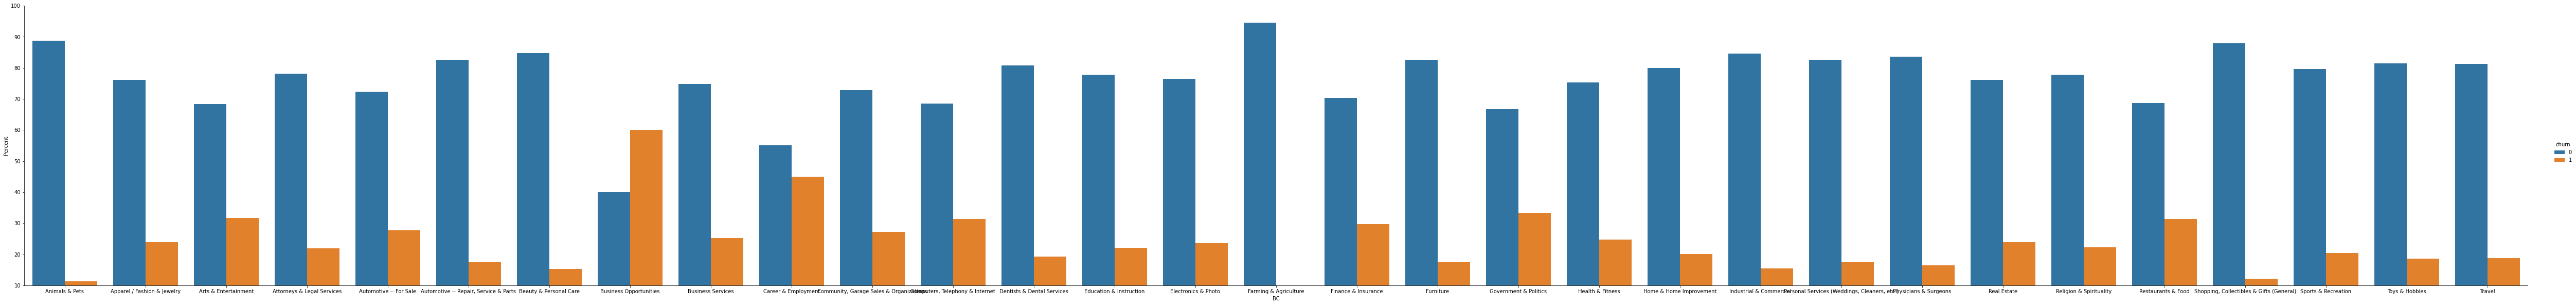

In [14]:
g = sns.catplot(x='BC', y='Percent', hue='churn', kind='bar', data=df_BC,height=8.27, aspect =100/12)
g.ax.set_ylim(10,100)

In [15]:
df_client_state = df.groupby('client_state')['churn'].value_counts(normalize=True)
df_client_state = df_client_state.mul(100).rename('Percent').reset_index()

(10.0, 100.0)

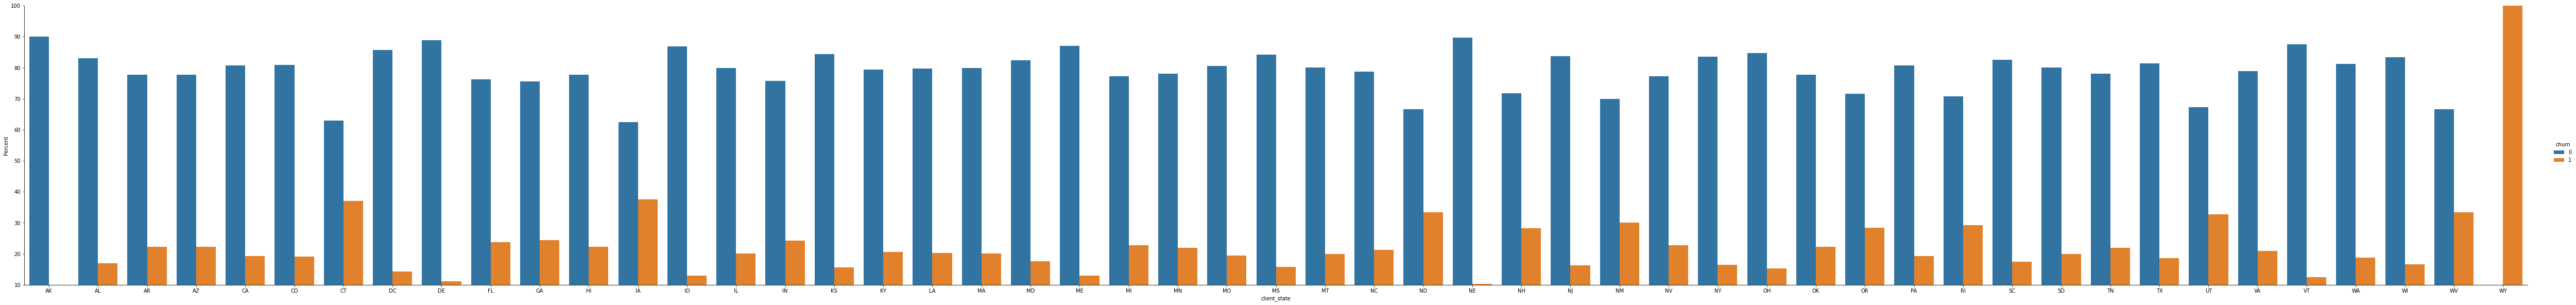

In [16]:
g = sns.catplot(x='client_state', y='Percent', hue='churn', kind='bar', data=df_client_state,height=8.27, aspect =100/12)
g.ax.set_ylim(10,100)

In [17]:
df_duration = df.groupby('duration')['churn'].value_counts(normalize=True)
df_duration = df_duration.mul(100).rename('Percent').reset_index()

(10.0, 100.0)

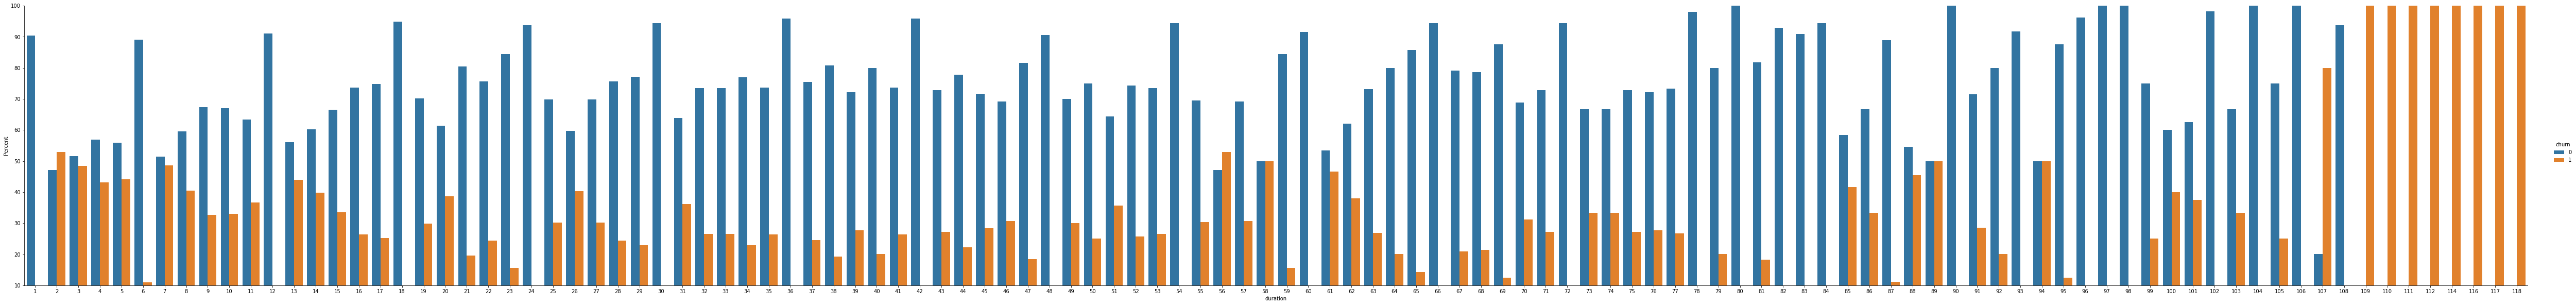

In [18]:
g = sns.catplot(x='duration', y='Percent', hue='churn', kind='bar', data=df_duration,height=8.27, aspect =100/12)
g.ax.set_ylim(10,100)

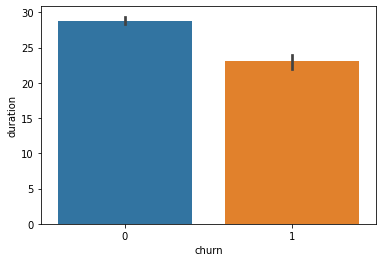

In [19]:
# Create a bar plot to observe the distribution of classes with time
sns.barplot(x = 'churn', y = 'duration', data = df)

<b>We can see long term customers are more likely to churn<b>

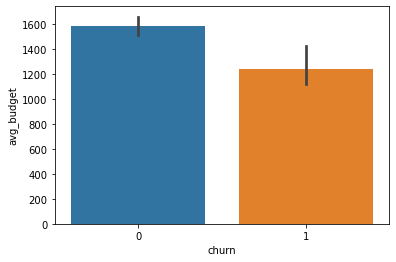

In [20]:
# Create a bar plot to observe the distribution of classes with avg_budget
sns.barplot(x = 'churn', y = 'avg_budget', data = df)

<b>We can see low value customers are likely to churn than high value customers

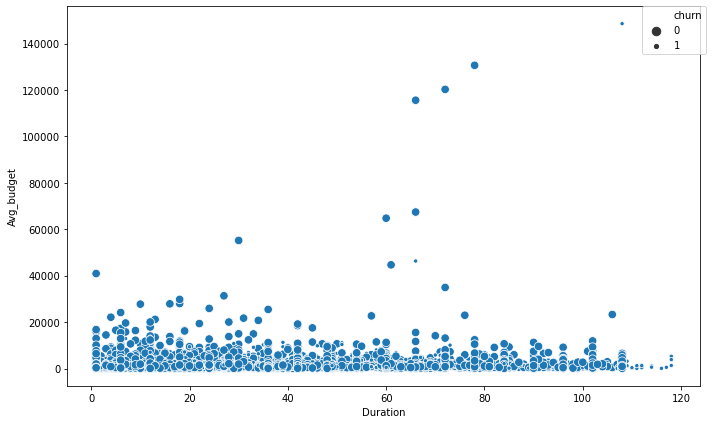

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='duration', 
                y='avg_budget',
                size='churn',            
                data=df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.01, 0.54),  borderaxespad=0.)
plt.xlabel("Duration")
plt.ylabel("Avg_budget")
plt.tight_layout()


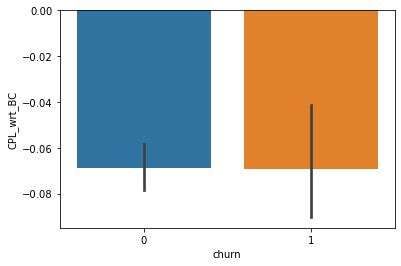

In [22]:
# Create a bar plot to observe the distribution of classes with CPL_wrt_BC
sns.barplot(x = 'churn', y = 'CPL_wrt_BC', data = df)

<b>We can see customers with high CPL_wrt_BC are more likely to retain<b>

In [23]:
df_num_prods = df.groupby('num_prods')['churn'].value_counts(normalize=True)
df_num_prods = df_num_prods.mul(100).rename('Percent').reset_index()

(10.0, 100.0)

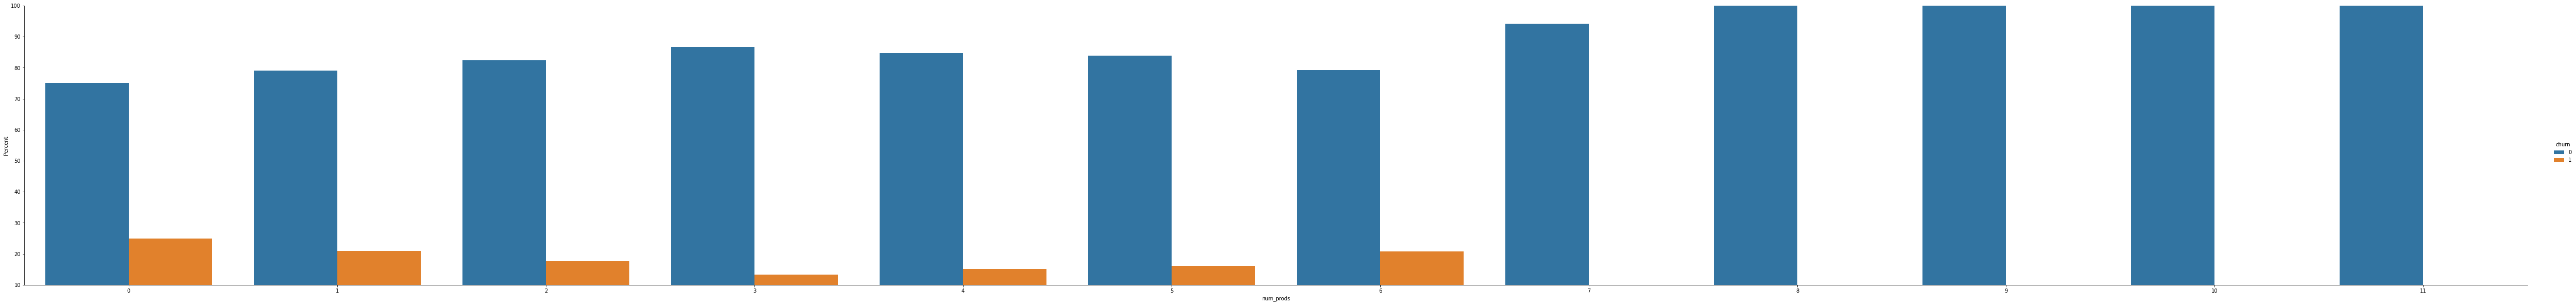

In [24]:
g = sns.catplot(x='num_prods', y='Percent', hue='churn', kind='bar', data=df_num_prods,height=8.27, aspect =100/12)
g.ax.set_ylim(10,100)

<b>We can see customers are more likely to retain as the number of products increases<b>

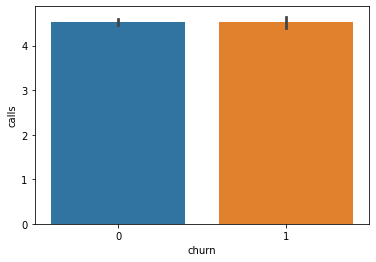

In [25]:
# Create a bar plot to observe the distribution of classes with calls
sns.barplot(x = 'churn', y = 'calls', data = df)

<b>Calls does not explain anything on churn rate<b>

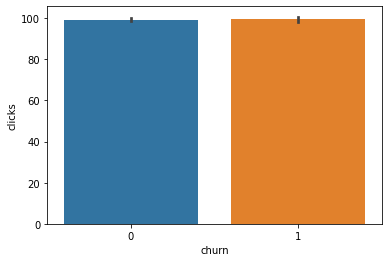

In [26]:
# Create a bar plot to observe the distribution of classes with clicks
sns.barplot(x = 'churn', y = 'clicks', data = df)

<b>Clicks does not explain anything on churn rate<b>

## Data Cleaning

### Removing NaN

In [27]:
# Replace null with 0(because CPL_wrt_self is independent of other rows)
df['CPL_wrt_self'] = df['CPL_wrt_self'].fillna(0)

### Encoding Categorical Variables

In [28]:
# Target Encoding to deal with high cardinality categorical features 
# without exploding dimensionality.
def target_encoder(df, column, target, index=None):
    index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied
    encoded_column = df[column].map(df.iloc[index].groupby(column)[target].mean())
    return encoded_column

In [29]:
df['BC'] = target_encoder(df, column='BC', target='churn')

In [30]:
df['client_state'] = target_encoder(df, column='client_state', target='churn')

### Normalization

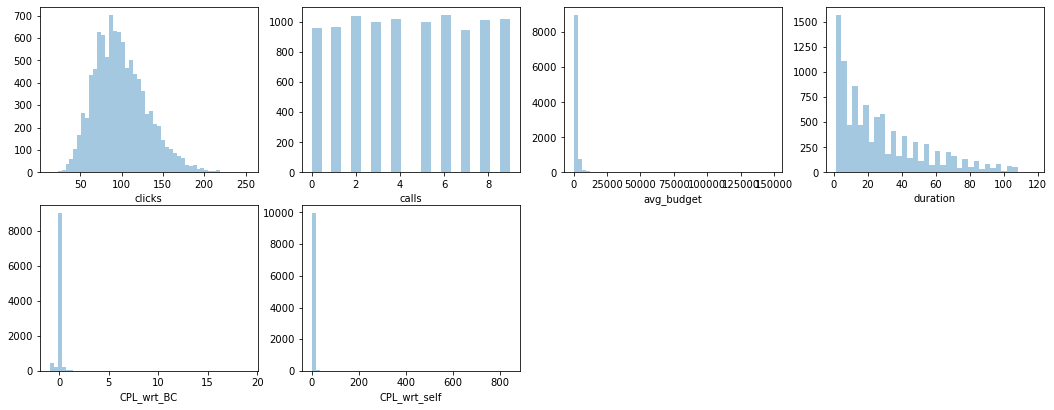

In [31]:
# plot the histogram of a variable from the dataset to see the skewness
plt.figure(figsize=(18,14))
cols = [ 'clicks', 'calls',  'avg_budget', 'duration', 'CPL_wrt_BC', 'CPL_wrt_self']
for i in enumerate(cols): 
    ax = plt.subplot(4, 4, i[0]+1)
    sns.distplot(df[i[1]], kde=False)

In [32]:
#Box - Cox transform duration
duration_box_cox = stats.boxcox(df['duration'])[0]
pd.Series(duration_box_cox).skew()
df.insert(0,'Duration', duration_box_cox)
df.drop('duration', axis=1, inplace=True)

In [33]:
#Box - Cox transform avg_budget
budget_box_cox = stats.boxcox(df['avg_budget'])[0]
pd.Series(budget_box_cox).skew()
df.insert(0,'Avg_budget', budget_box_cox)
df.drop('avg_budget', axis=1, inplace=True)

### Identify and Remove columns with no variance

In [34]:
#Identify columns with no variance
no_var_col=[]
for each in df.columns:
    if df[each].nunique() == 1:
        no_var_col.append(each)
no_var_col

[]

### Correlation Matrix and Heatmap

In [35]:
corr_df = pd.DataFrame(df.drop('churn', axis=1).corr().unstack().sort_values().drop_duplicates(), columns=['corr_score'])

In [36]:
#correlation Matrix
cor= df.drop(['churn'], axis=1).corr()

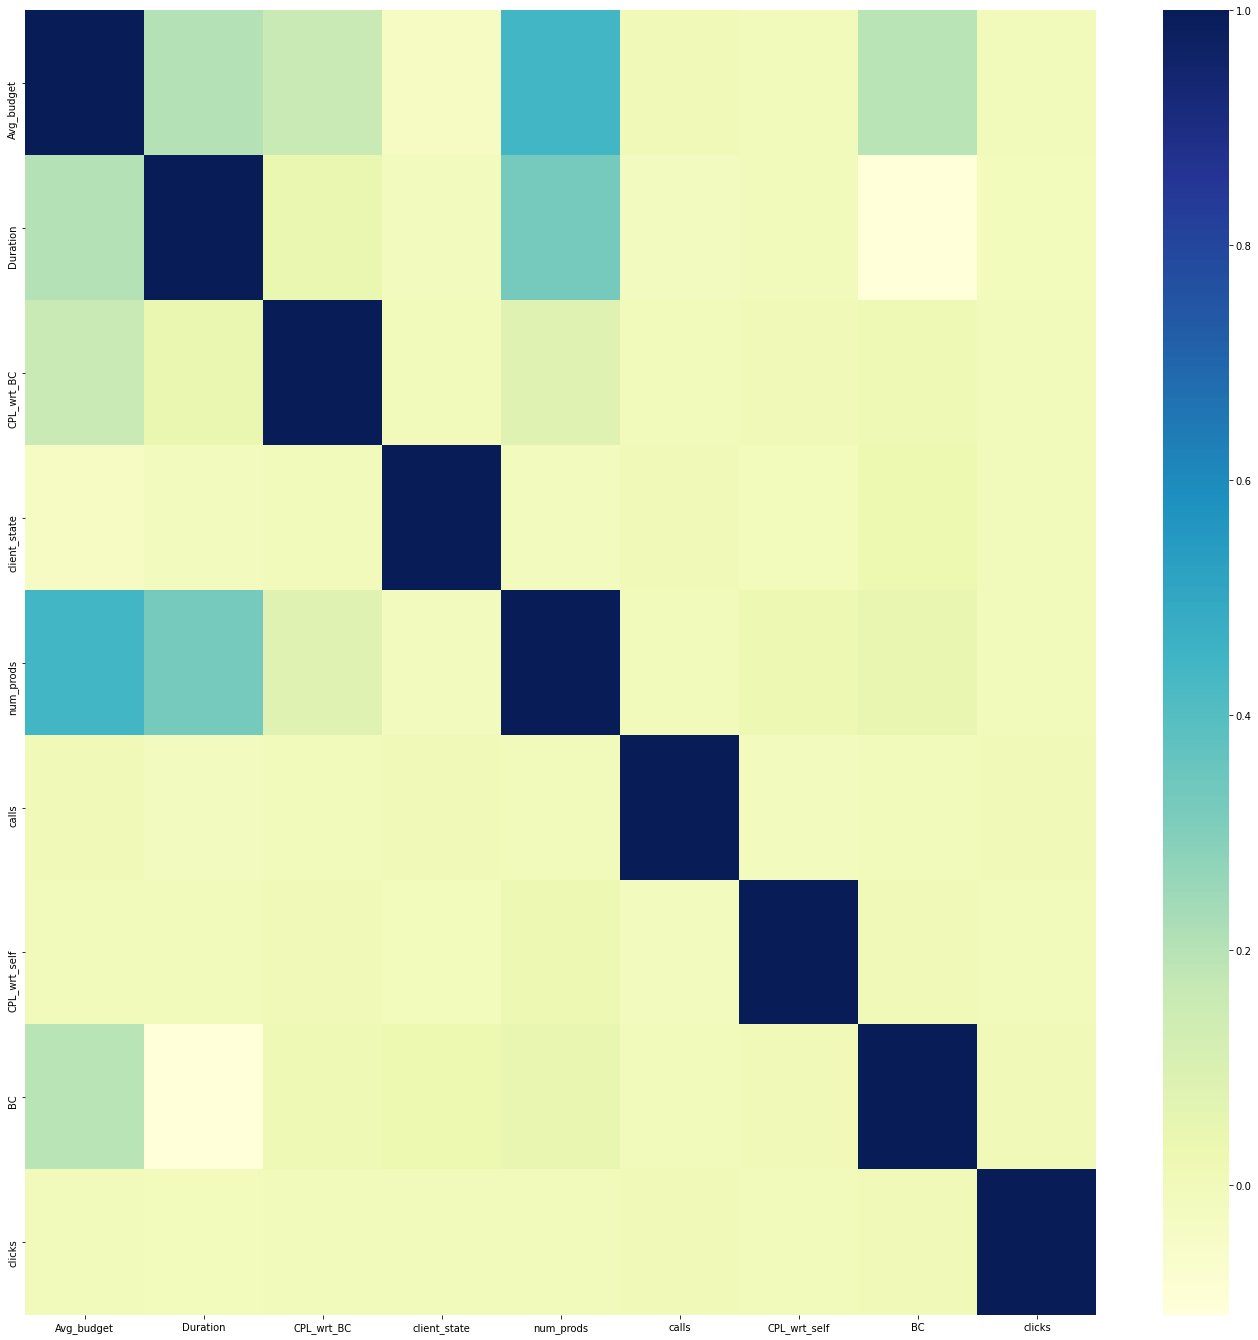

In [37]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(24,24))

# heatmap
sns.heatmap(cor, cmap="YlGnBu",)
plt.show()

<b>No highly correlated columns in the heat map

### Checking Outliers

In [38]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%

df.drop(['churn'], axis=1).describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Avg_budget,Duration,CPL_wrt_BC,client_state,num_prods,calls,CPL_wrt_self,BC,clicks
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.809877,4.502705,-0.068958,0.200000,1.327200,4.526100,0.536853,0.200000,99.214900
std,1.363912,2.511238,0.491693,0.035589,0.816582,2.859185,10.511881,0.046374,31.701757
min,2.309411,0.000000,-0.994590,0.100000,0.000000,0.000000,-1.000000,0.055556,13.000000
25%,7.007687,2.309299,-0.103273,0.186592,1.000000,2.000000,-0.215060,0.174679,76.000000
50%,7.848237,4.514403,-0.088810,0.193123,1.000000,5.000000,0.000000,0.201149,96.000000
75%,8.659568,6.487732,-0.048530,0.213115,1.000000,7.000000,0.245392,0.221477,119.000000
90%,9.463860,7.818048,0.000664,0.237265,2.000000,9.000000,0.847317,0.251928,142.000000
95%,9.977826,8.517495,0.101739,0.243478,3.000000,9.000000,1.594276,0.277132,157.000000
99%,11.185288,9.263699,0.808168,0.333333,5.000000,9.000000,7.185472,0.317073,188.000000


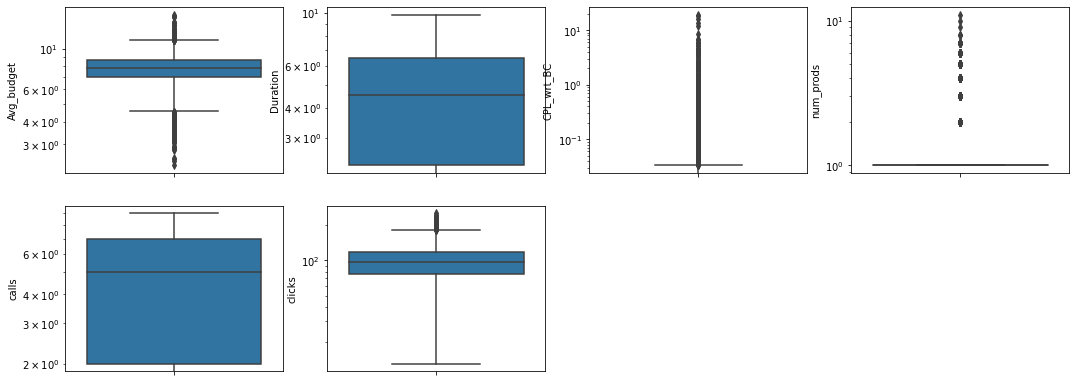

In [39]:
# Boxplot for numeric variables 
plt.figure(figsize=(18,14))
cols = ['Avg_budget', 'Duration', 'CPL_wrt_BC', 'num_prods','calls', 'clicks']
for i in enumerate(cols): 
    ax = plt.subplot(4, 4, i[0]+1)
    plt.yscale('log')
    sns.boxplot(y=i[1], data=df) 

In [40]:
# Looping through each variable with outliers

for i in df.columns:
    if 'client_state' in i:
        continue
    elif 'churn' in i:
        continue
    elif 'BC' in i:
        continue
    else:
        upper_fence = df[i].quantile(0.99)            # taking the value of 99th percentile for each column

        # Replacing all the values higher than the upper fence with the value of upper fence
        df[i][df[i] >= upper_fence] = upper_fence

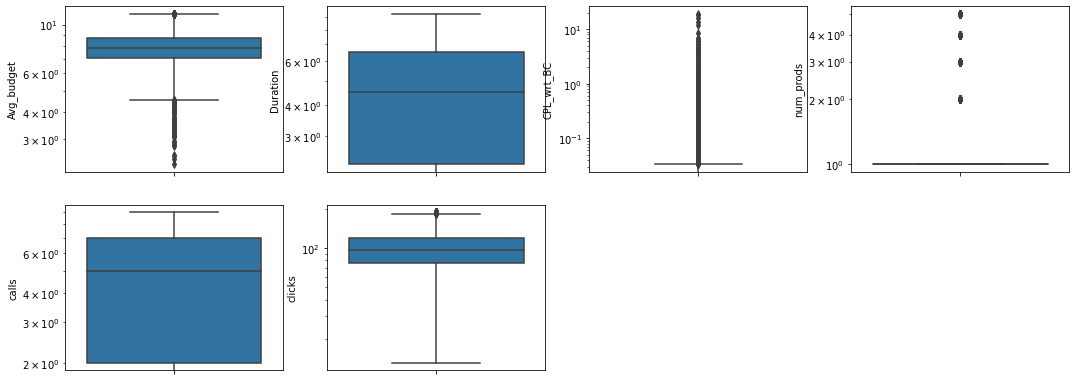

In [41]:
# Boxplot for numeric variables 
plt.figure(figsize=(18,14))
cols = ['Avg_budget', 'Duration', 'CPL_wrt_BC', 'num_prods','calls', 'clicks']
for i in enumerate(cols): 
    ax = plt.subplot(4, 4, i[0]+1)
    plt.yscale('log')
    sns.boxplot(y=i[1], data=df)  

## Data Preparation

### Upsample minority class - Resampling, Random Sampling, SMOTE, ADASYN

<b>Upsampling, to make the counts of both labels same. 
This prevents the model from inclining towards the majority class and 
the interaction(boundary line)between the target classes remains unaltered.

In [42]:

# Separate majority and minority classes
df_majority = df[df.churn==0]
df_minority = df[df.churn==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=100) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.churn.value_counts()

1    8000
0    8000
Name: churn, dtype: int64

In [43]:
#split into train-test
x = df.drop('churn', axis = 1)
y= df['churn']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.8, random_state=10)

In [44]:
#balance classes using Random Oversampling
oversample= RandomOverSampler(random_state=10)
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

In [45]:
#balance classes using SMOTE
sm = SMOTE(random_state=10)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [46]:
#balance classes using ADASYN
ada = ADASYN(random_state=10)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)

### Train-Test Split

In [47]:
y= df_upsampled['churn']

In [48]:
x = df_upsampled.drop('churn', axis = 1)

In [49]:
#split into train-test (80-20 split)
x_train_upsampled, x_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(x, y, stratify=y, train_size=0.8, random_state=10)


### Scaling and Power Transforming

In [50]:
#Minmax scaling 
min_max_scaler = preprocessing.MinMaxScaler()
scaler = MinMaxScaler()
x_train_upsampled = scaler.fit_transform(x_train_upsampled)
x_test_upsampled = scaler.transform(x_test_upsampled)

In [51]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer(method='yeo-johnson',copy=False)
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

## Modeling

### Defining Evaluation Metrics

<b><br>Our business objective is to correctly predict all the churn customers and this indicates a need for high sensitivity rather than specificity. But giving too much importance to Sensitivity will also be a costly choice. So, we are using roc_auc for our evaluation metric<b>

In [52]:
# Model evaluation 
def model_scores(y_test, y_pred):
    f1_val = metrics.f1_score(y_test, y_pred)
    prec_val = metrics.precision_score(y_test, y_pred)
    recall_val = metrics.recall_score(y_test, y_pred)
    roc_auc_val = metrics.roc_auc_score(y_test , y_pred)
    print()
    print('F1 ={0}, Precision = {1}, Recall = {2}, ROC_AUC={3}'.format(f1_val, prec_val, recall_val, roc_auc_val))
    print()

    #printing the confusion matrix
    conf_mat =  confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_labels = ['Retention', 'Churn']
    plt.figure(figsize=(4,2))
    sns.heatmap(conf_mat, xticklabels=plot_labels,
     yticklabels=plot_labels, annot=True, fmt='d');
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

### Logistic Regression


F1 =0.11403508771929824, Precision = 0.4642857142857143, Recall = 0.065, ROC_AUC=0.523125



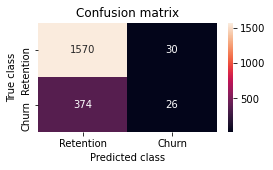

In [53]:
# instantiate object
logreg = LogisticRegression(random_state=10)

#fit model
lr_model = logreg.fit(X_train, y_train)
# predict values 
y_pred=lr_model.predict(X_test)
model_scores(y_test, y_pred)


F1 =0.35262083049693665, Precision = 0.2422825070159027, Recall = 0.6475, ROC_AUC=0.5706249999999999



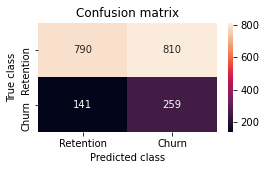

In [54]:
#Logistic Regression on Random Oversampled train data

#fit model
lr_model_oversampled = logreg.fit(X_train_oversampled, y_train_oversampled)
# predict values 
y_pred=lr_model_oversampled.predict(X_test)
model_scores(y_test, y_pred)


F1 =0.3554301833568407, Precision = 0.2475442043222004, Recall = 0.63, ROC_AUC=0.5756249999999999



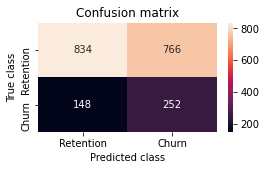

In [55]:
#Logistic Regression on SMOTE train data

#fit model
lr_model_smote = logreg.fit(X_train_smote, y_train_smote)
# predict values 
y_pred=lr_model_smote.predict(X_test)
model_scores(y_test, y_pred)


F1 =0.35263432446531034, Precision = 0.2228081740276862, Recall = 0.845, ROC_AUC=0.5540625



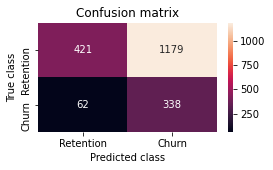

In [56]:
#Logistic Regression on ADASYN train data

#fit model
lr_model_adasyn = logreg.fit(X_train_adasyn, y_train_adasyn)
# predict values 
y_pred=lr_model_adasyn.predict(X_test)
model_scores(y_test, y_pred)

### PCA

In [57]:
# instantiate object
pca = PCA(random_state=100)

In [58]:
# fit PCA on train data
pca.fit(X_train)

PCA(random_state=100)

In [59]:
# components derived
pca.components_

array([[-5.42187336e-01, -4.45333698e-01, -4.29670518e-01,
         1.79703469e-02, -5.57920553e-01, -3.91027743e-04,
         1.65588886e-02, -1.05918958e-01,  1.60755604e-03],
       [ 3.09499676e-01, -4.20554959e-01, -1.80787227e-01,
         2.04699973e-01,  3.50590808e-02,  1.20875761e-01,
         1.26857634e-01,  7.87241836e-01,  3.27829214e-02],
       [-1.49119796e-02, -3.19165937e-02,  8.26924982e-02,
         1.82437403e-01, -4.85255784e-02, -1.03256709e-02,
        -7.36882065e-01,  5.61885354e-02,  6.40331031e-01],
       [ 6.48163847e-02, -5.54887374e-02, -8.55645921e-02,
        -3.98793559e-01, -4.96573039e-03, -8.76668254e-01,
        -1.35423137e-01,  1.88212982e-01, -6.34570305e-02],
       [ 6.26586245e-02, -4.93385980e-02, -8.76114522e-02,
        -7.60785549e-01,  2.60957633e-02,  2.92013830e-01,
         2.43001058e-01,  2.02479809e-02,  5.11621561e-01],
       [ 3.85536668e-02, -8.86757325e-02,  7.60857302e-02,
        -4.27804951e-01, -8.30547712e-02,  3.543352

In [60]:
# variance explained by each component
pca.explained_variance_ratio_

array([0.21319474, 0.12823682, 0.11400165, 0.11158921, 0.11082885,
       0.10778903, 0.08729678, 0.0744343 , 0.05262863])

In [61]:
# cumulative variance explained by the principal components
var_cumu = np.cumsum(pca.explained_variance_ratio_)

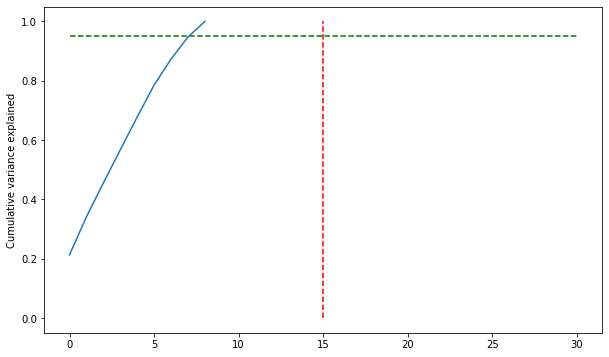

In [62]:
# plot for cumulative variance explained
fig = plt.figure(figsize=[10,6])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [63]:
# to extract components that cumulatively explain 90% of variance
pca_90 = PCA(0.90)

In [64]:
# fit PCA to the train data
df_train_pca = pca_90.fit_transform(X_train)

In [65]:
# transform test set based on PCA
df_test_pca = pca_90.transform(X_test)

In [66]:
df_test_pca.shape

(2000, 8)

In [67]:
# function for evaluating decision tree with pca
def evaluate_pca_model(classifier):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(df_train_pca)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(df_train_pca)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(df_test_pca)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, classifier.predict(df_test_pca)))

<b>After PCA, we can see that all the features are needed to explain the variance in target variable. 
So we will retain all features for model building

### Logistic Regression with PCA

In [68]:
# instantiate the object
logreg_pca = LogisticRegression()

In [69]:
# fit logistic regression model on df_train_pca
LR_pca = logreg_pca.fit(df_train_pca, y_train)

In [70]:
# predict values for training data
y_train_pred = LR_pca.predict_proba(df_train_pca)[:,1]

In [71]:
# view predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train.values, 'churn_prob':y_train_pred})
y_train_pred_final.head()

,churn,churn_prob
0,0,0.202359
1,0,0.233574
2,0,0.141525
3,0,0.123591
4,0,0.359471


In [72]:
# create columns with different probability cutoffs 
numbers = [0.0,0.1,0.2,0.3,0.4,0.48,0.5,0.52,0.54,0.6,0.7,0.8,0.9]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.churn_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.48,0.5,0.52,0.54,0.6,0.7,0.8,0.9
0,0,0.202359,1,1,1,0,0,0,0,0,0,0,0,0,0
1,0,0.233574,1,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.141525,1,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0.123591,1,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0.359471,1,1,1,1,0,0,0,0,0,0,0,0,0


In [73]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.48,0.5,0.52,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      prob  accuracy  sensitivity  specificity
0.00  0.00  0.200000     1.000000     0.000000
0.10  0.10  0.306375     0.932500     0.149844
0.20  0.20  0.629000     0.611250     0.633437
0.30  0.30  0.780875     0.305625     0.899687
0.40  0.40  0.805875     0.152500     0.969219
0.48  0.48  0.807125     0.082500     0.988281
0.50  0.50  0.804750     0.063125     0.990156
0.52  0.52  0.803625     0.050000     0.992031
0.60  0.60  0.802250     0.016250     0.998750
0.70  0.70  0.800875     0.004375     1.000000
0.80  0.80  0.800125     0.000625     1.000000
0.90  0.90  0.800000     0.000000     1.000000


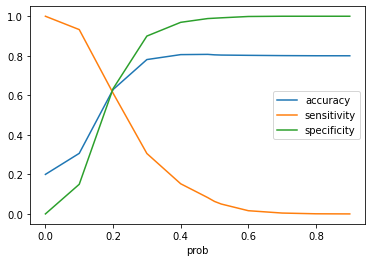

In [74]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

<b>As we can see, the threshold as per the curve is 0.25, which would provide all metrics in the range of 60%
But our business objective is to correctly predict all the churn customers and this indicates a need for high sensitivity rather than specificity. 
Hence we will choose threshold of 0.25<b>

In [75]:
# we will take the threshold value as 0.25
y_train_pred_final['final_predicted'] = y_train_pred_final.churn_prob.map( lambda x: 1 if x > 0.25 else 0)

y_train_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.48,0.5,0.52,0.54,0.6,0.7,0.8,0.9,final_predicted
0,0,0.202359,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0.233574,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0.141525,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.123591,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.359471,1,1,1,1,0,0,0,0,0,0,0,0,0,1


In [76]:
# predictions for test set
y_test_pred = LR_pca.predict_proba(df_test_pca)[:,1]

In [77]:
y_test_pred_final = pd.DataFrame({'churn':y_test.values, 'churn_prob':y_test_pred})
y_test_pred_final.head()

,churn,churn_prob
0,1,0.210109
1,0,0.167067
2,0,0.041337
3,1,0.197504
4,0,0.288779


<b> Prediction class probabilities are too low to trust the model. Moving on to cluster classification methods like KNN

### KNN


F1 =0.2163120567375887, Precision = 0.3719512195121951, Recall = 0.1525, ROC_AUC=0.5440625



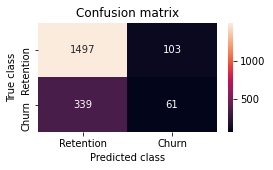

In [78]:
#instantiate object
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#fit model
knn_model = knn.fit(X_train, y_train)
# predict values 
y_pred=knn_model.predict(X_test)
model_scores(y_test, y_pred)

#### KNN on Random Random Oversampled dataset


F1 =0.0, Precision = 0.0, Recall = 0.0, ROC_AUC=0.4996875



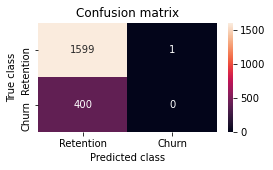

In [79]:
#fit model
knn_model_oversampled = knn.fit(X_train_oversampled, y_train_oversampled)
# predict values 
y_pred=knn_model_oversampled.predict(X_test)
model_scores(y_test, y_pred)

#### KNN on Random SMOTE Oversampled dataset


F1 =0.0, Precision = 0.0, Recall = 0.0, ROC_AUC=0.5



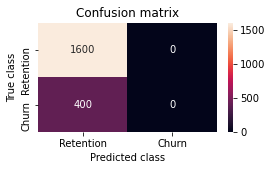

In [80]:
#fit model
knn_model_smote = knn.fit(X_train_smote, y_train_smote)
# predict values 
y_pred=knn_model_smote.predict(X_test)
model_scores(y_test, y_pred)

#### KNN on Random ADASYN Oversampled dataset


F1 =0.0, Precision = 0.0, Recall = 0.0, ROC_AUC=0.5



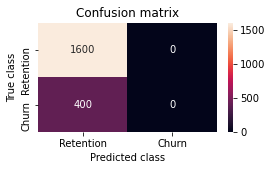

In [81]:
#fit model
knn_model_adasyn = knn.fit(X_train_adasyn, y_train_adasyn)
# predict values 
y_pred=knn_model_adasyn.predict(X_test)
model_scores(y_test, y_pred)

### Trying Ensembles

### Random Forest


F1 =0.39068100358422936, Precision = 0.689873417721519, Recall = 0.2725, ROC_AUC=0.6209374999999999



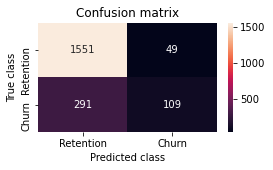

In [82]:
#instantiate object
rf = RandomForestClassifier(random_state=10, n_estimators=1000)
#fit model
rf_model = rf.fit(X_train, y_train)
#predict values
y_pred = rf_model.predict(X_test)
model_scores(y_test, y_pred)

#### Random Forest on Random Oversampled dataset


F1 =0.07439824945295406, Precision = 0.2982456140350877, Recall = 0.0425, ROC_AUC=0.5087499999999999



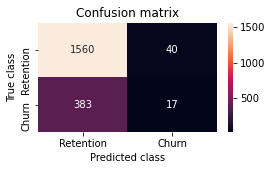

In [83]:
#fit model
rf_model_oversampled = rf.fit(X_train_oversampled, y_train_oversampled)
#predict values
y_pred = rf_model_oversampled.predict(X_test)
model_scores(y_test, y_pred)

#### Random Forest on Smote Oversampled dataset


F1 =0.22914072229140722, Precision = 0.228287841191067, Recall = 0.23, ROC_AUC=0.5178125



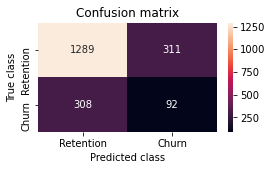

In [84]:
#fit model
rf_model_smote = rf.fit(X_train_smote, y_train_smote)
#predict values
y_pred = rf_model_smote.predict(X_test)
model_scores(y_test, y_pred)

#### Random Forest on ADASYN Oversampled dataset


F1 =0.2164090368608799, Precision = 0.20634920634920634, Recall = 0.2275, ROC_AUC=0.504375



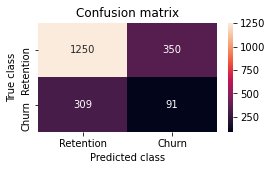

In [85]:
#fit model
rf_model_adasyn = rf.fit(X_train_adasyn, y_train_adasyn)
#predict values
y_pred = rf_model_adasyn.predict(X_test)
model_scores(y_test, y_pred)



<b>Trying Boosting methods since we have identified in EDA that the features are not strong enough to successfully classify churn. The above classifiers fail to classify churn even with oversampling. 



### AdaBoost

In [86]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=10000,
)
classifier.fit(x_train_upsampled, y_train_upsampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=10000)

In [87]:
y_pred = classifier.predict(x_test_upsampled)

In [88]:
confusion_matrix(y_test_upsampled, y_pred)

array([[1222,  378],
       [ 322, 1278]])


F1 =0.7850122850122849, Precision = 0.7717391304347826, Recall = 0.79875, ROC_AUC=0.7812500000000001



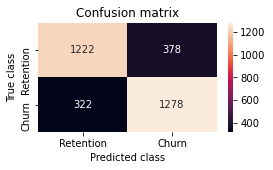

In [89]:
model_scores(y_test_upsampled, y_pred)

In [90]:
print("Accuracy:" , metrics.accuracy_score(y_test_upsampled, y_pred))

Accuracy: 0.78125


#### Grid Search

In [91]:
#Grid search to find the optimal hyperparameters
cross_val = StratifiedKFold(n_splits = 4)
clf = AdaBoostClassifier()
params =  {
    'n_estimators': [150, 10000],
    'learning_rate':[0.001, 1.0]
}

# Instantiate the grid search model
clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=cross_val, n_jobs=2, scoring = "roc_auc")

In [92]:
%%time
clf_grid.fit(x_train_upsampled, y_train_upsampled)

CPU times: user 1min 2s, sys: 167 ms, total: 1min 2s
Wall time: 4min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(), n_jobs=2,
             param_grid={'learning_rate': [0.001, 1.0],
                         'n_estimators': [150, 10000]},
             scoring='roc_auc')

In [93]:
ada_best = clf_grid.best_estimator_
predictions=ada_best.predict(x_test_upsampled)
clf_grid.best_params_

{'learning_rate': 1.0, 'n_estimators': 10000}


F1 =0.7850122850122849, Precision = 0.7717391304347826, Recall = 0.79875, ROC_AUC=0.7812500000000001



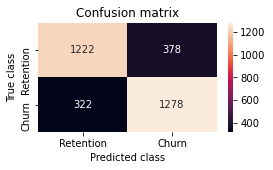

In [94]:
model_scores(y_test_upsampled, predictions)

<b>AdaBoost has shown considerable improvement in the overall metrics. We can see boosting methods work well on this data as the model gets more stability.
The instability we have seen so far is because there are features that are only partially relevant to the target variable. There is a very little information gain from the features.
Boosting has improved model generalization by combining several estimates from different models.
Let us try to improve metrics with other boosting methods.

# FINALISED MODEL

## Gradient Boosting Classifier


F1 =0.9129022733982877, Precision = 0.8651371012870733, Recall = 0.96625, ROC_AUC=0.9078125



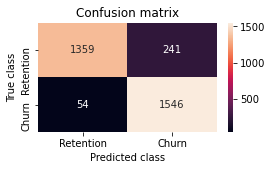

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf2 = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.5, max_features=3, max_depth=2, random_state=0)
gb_clf2.fit(x_train_upsampled, y_train_upsampled)
predictions_GB = gb_clf2.predict(x_test_upsampled)
model_scores(y_test_upsampled, predictions_GB)

#### Grid search

In [96]:
#Grid search to find the optimal hyperparameters
cross_val = StratifiedKFold(n_splits = 4)
clf = GradientBoostingClassifier()
params =  {
    'n_estimators': [150, 3500],
    'max_depth':[2,9],
    'max_features':[2,9]
}

# Instantiate the grid search model
clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=cross_val, n_jobs=2, scoring = "roc_auc")

In [97]:
%%time
clf_grid.fit(x_train_upsampled, y_train_upsampled)

CPU times: user 2min 15s, sys: 195 ms, total: 2min 15s
Wall time: 8min 56s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=2,
             param_grid={'max_depth': [2, 9], 'max_features': [2, 9],
                         'n_estimators': [150, 3500]},
             scoring='roc_auc')

In [98]:
gb_best = clf_grid.best_estimator_
predictions=gb_best.predict(x_test_upsampled)
clf_grid.best_params_

{'max_depth': 9, 'max_features': 9, 'n_estimators': 3500}


F1 =0.9594594594594595, Precision = 0.9432367149758454, Recall = 0.97625, ROC_AUC=0.9587499999999999



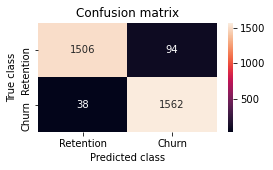

In [99]:
model_scores(y_test_upsampled, predictions)

In [100]:
print("Accuracy:" , metrics.accuracy_score(y_test_upsampled, predictions))

Accuracy: 0.95875


**Finalised Model Metrics:::**
<b>
F1 =0.9594594594594595, Precision = 0.9432367149758454, Recall = 0.97625, ROC_AUC=0.9587499999999999, Accuracy: 0.95875

#### Extracting Feature Importance from Gradient Boost Classifier

In [101]:
#Extracting feature importance from gradient boost Classifier
x_axis = ["CPL_wrt_BC","client_state","duration","num_prods", "calls","CPL_wrt_self","avg_budget","BC","clicks"]
y_axis = gb_best.feature_importances_

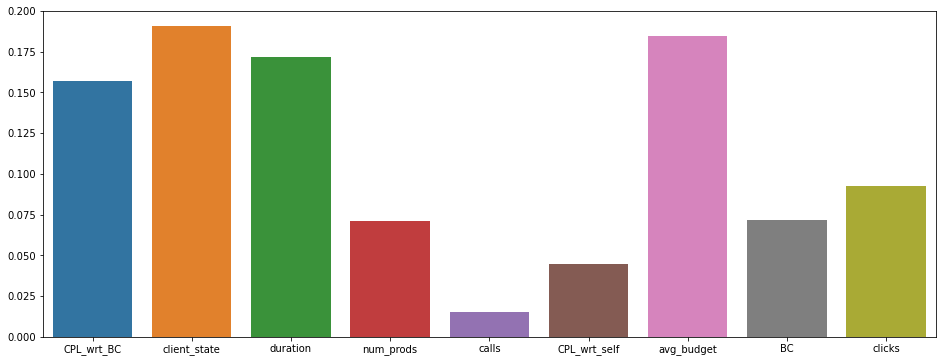

In [102]:
plt.figure(figsize=(16, 6))
sns.barplot(x_axis,y_axis)

## Churn Indicators

<b>Based on the feature importance as given by Gradient Boost Classifier, we can conclude that the top 4 variables indicating churn are:

1. client_state
2. avg_budget
3. duration
4. CPL_wrt_BC

Client State and the Average Budget are the most important indicators of churn. Also, the duration and the CPL_wrt_BC amount also indicate whether a customer will churn or not.
The business should keep track of these important predictor variables. 

## Recommendations

<b>According to our model, Client State and the Average Budget are the most important indicators of churn. Also, the duration and the CPL_wrt_BC amount also indicate whether a customer will churn or not. The business should keep track of these important predictor variables.

Also from the EDA, we have learnt that 
* Long term customers are likely to churn 
* Low value customers are likely to churn than high value customers
* We can see customers with high CPL_wrt_BC are more likely to retain. 
* Customers likely to retain when num_products are high

<p>1)We can use this model to predict the churn with high Recall and Precision. After predicting the churn customers, we need to provide some offer or incentive to those customers to retain them in the network.


<p>2)Based on feature importance we can see that customer state is a very important feature and we need to identify states with high percentage of churn and work on drilling down to identify the issues causing churn.
<p>3)Also, the customers may want to see change in CPL_wrt_BC over time, they need to reach more customers over time.
<p>4)Low value customers are may be trying out the advertising effectiveness and are churning because they don't get expected results. We need to provide additional value-added services to retain such customers. 

Further, data collection on some more features that could be more relevant to the target variable would be advisable. For example, if we had monthly data for each customer, we could learn why the customer would become unhappy and decide to churn.
